In [1]:
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))
import numpy as np; np.set_printoptions(linewidth=130);
# first we need a bit of import boilerplate
import os
import sys
from sys import platform
if platform == 'win32':
    sys.path.append('D:/Brain_Network/Code/')
    manifest_path = 'D:/Brain_Network/Data/Allen_Institute_Dataset/manifest.json'
    project_dir = 'D:/Brain_Network/'
elif platform =='darwin':
    sys.path.append('/Users/chenyu/Workspace/Brain_Network/Code/')
    manifest_path = '/Users/chenyu/Workspace/Brain_Network/Data/Allen_Institute_Dataset/manifest.json'
    project_dir = '/Users/chenyu/Workspace/Brain_Network/'
elif platform == 'linux':
    sys.path.append('/home/yuchen/workspace/Brain_Network/Code/')
    manifest_path = '/home/yuchen/workspace/Brain_Network/Data/Allen_Institute_Dataset/manifest.json'
    project_dir = '/home/yuchen/workspace/Brain_Network/'
else:
    print('Add new computer system settings.')

import glob
from tqdm import tqdm
from tqdm.notebook import trange
import time

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
from allensdk.brain_observatory.ecephys.ecephys_session import EcephysSession

import hierarchical_model_generator
import hierarchical_sampling_model
import samples

In [2]:
import pandas as pd
print('pd', pd.__version__)
import allensdk
print('allensdk', allensdk.__version__)
import h5py
print('h5py', h5py.__version__)
import pynwb
print('pynwb', pynwb.__version__)
import hdmf
print('hdmf', hdmf.__version__)

pd 1.1.1
allensdk 2.2.0
h5py 2.8.0
pynwb 1.4.0
hdmf 2.2.0


# Hierarchical model

### Load tamplate model

In [3]:
model_files = [
'HBM_checkpoint_B_MC_0_500ms_probeCE_condition1_20200813-092937_generator_template.pkl',
'HBM_checkpoint_BSS_MC_0_500ms_probeCE_o225_270_f8_20200801-174224_generator_template.pkl',
'HBM_checkpoint_BSS_MC_0_500ms_probeCDE_o225_270_f8_20200731-125456_generator_template.pkl',
'798911424_checkpoints_batch5_20201111-121627_generator_template.pkl', # B A3
'798911424_checkpoints_batch14_20201023-042306_generator_template.pkl']  # BSS A3

### Generate data.

In [23]:
random_seed = 0

print(f'---------------------- {random_seed} --------------------')
## Load simulation
generator_model = hierarchical_model_generator.HierarchicalModelGenerator()
data_folder = project_dir + 'Output/simulation/'
file_path = (data_folder + model_files[4])
generator_model.load_model(file_path)

np.random.seed(random_seed)  # Random seed for pseudo data.
model_feature_type = 'BSS'
generator_model.initial_step(model_feature_type=model_feature_type, num_trials=60, num_conditions = 1)

## Generate data
select_clist = [4]
generator_model.generate_mu_sigma(sample_type='fixed', verbose=False)
generator_model.generate_q()
generator_model.generate_f_pop_gac(select_clist=select_clist, same_as_cross=False, verbose=False)
generator_model.generate_z(verbose=False)
generator_model.generate_p_gac(verbose=False)
generator_model.generate_log_lambda_nargc(variation='laplacian', laplacian_scalar=20, verbose=False)
generator_model.generate_spikes(verbose=False)

## Prepare for the data fitting.
trial_time_window=generator_model.trial_time_window
spike_train_time_line = generator_model.spike_train_time_line
spike_trains, spike_times = generator_model.spike_trains, generator_model.spike_times
session = None
spike_counts, spike_shifts = generator_model.spike_counts, generator_model.spike_shifts
units_probes = generator_model.selected_units['probe_description']
probes = generator_model.probes
selected_units = generator_model.selected_units
trials_indices = generator_model.trials_indices
trials_groups = generator_model.trials_groups

---------------------- 0 --------------------
model_feature_type: BSS

num areas 3   num trials 60   num conditions 1   num qs 3


### Model fitting.

In [24]:
## Initial HBM
np.random.seed(0)  # Random seed for MCMC chain.
model = hierarchical_sampling_model.HierarchicalSamplingModel(session)
model.initial_step(spike_trains, spike_times, spike_train_time_line, selected_units, trials_groups,
                   trial_time_window, probes=['probeC', 'probeD', 'probeE'], num_areas=3, num_groups=3, 
                   model_feature_type='BSS', prior_type='diag',
                   eta_smooth_tuning=3e-8, verbose=False)
# Initialize with true values.
model.set_model(generator_model, select_clist=select_clist)

##
clist = [0]
thin_begin = 0
thin_step = 1

t = tqdm(range(500), file=sys.stdout, ncols=100)
for itr in t:
    slc = (itr >= thin_begin) and (itr % thin_step == 0)
    for c in clist:
        if itr < 20:
            model.update_f_local_pop_cag(c, sample_type='fit', verbose=False)
            model.update_f_cross_pop_ca(c, sample_type='fit', record=(c==clist[-1] and slc), verbose=False)
        if itr > 20:
            model.update_f_local_pop_cag(c, sample_type='sample', verbose=False)
            model.update_f_cross_pop_ca(c, sample_type='sample', record=(c==clist[-1] and slc), verbose=False)
        model.update_q_arc(c, sample_type='sample', proposal_scalar=0.02, fit_peak_ratio=0,
                           record=(c==clist[-1] and slc), verbose=False)  # proposal_scalar=0.1 BA2  0.04 BSS A3
        if itr > 150 and itr % 10 == 0:
            model.update_z_ngac(c, sample_type='sample', record=(c==clist[-1]), verbose=False)
        if itr > 150:
            model.update_p_gac(c, sample_type='sample', record=(c==clist[-1] and slc), verbose=False)
    if itr > 150:
        model.update_mu_simga(clist=clist, sample_type='iw_sample', record=slc, verbose=False)
    model.complete_log_likelihood(clist)
    t.set_description(f'{model.samples.log_likelihood[-1]:.2f} | {model.samples.q_accept_ratio_mean:.3f}')


Model feature type:  BSS
Condition: 0  stimulus_condition_id:0.0
probeC g:[2 1 0] counts:[38 32 24]  probeD g:[2 1 0] counts:[31 28 19]  probeE g:[2 1 0] counts:[36 31 22]  
-280936.36 | 0.280: 100%|█████████████████████████████████████████| 500/500 [11:36<00:00,  1.39s/it]


# Output

In [ ]:
# Save data.
experiment_name = f'{model_feature_type}_0_500ms_probe3_R{len(trials_indices)}_'
timestr = time.strftime("%Y%m%d-%H%M%S")
output_folder = project_dir + 'Output/simulation_output/BSS_A3_R180/'

# Save estimated model.
prefix = f'HBM_checkpoint_seed{random_seed}_'
file_path = output_folder + prefix + experiment_name + timestr + '.pkl'
model.save_model(save_data=False, file_path=file_path)
# Save true model.
prefix = f'HBM_generator_seed{random_seed}_'
file_path = output_folder + prefix + experiment_name + timestr + '.pkl'
generator_model.save_data(save_spikes=False, file_path=file_path)
# Save samples.
prefix = f'HBM_samples_seed{random_seed}_'
file_path = output_folder + prefix + experiment_name + timestr + '.pkl'
model.samples.save(file_path)

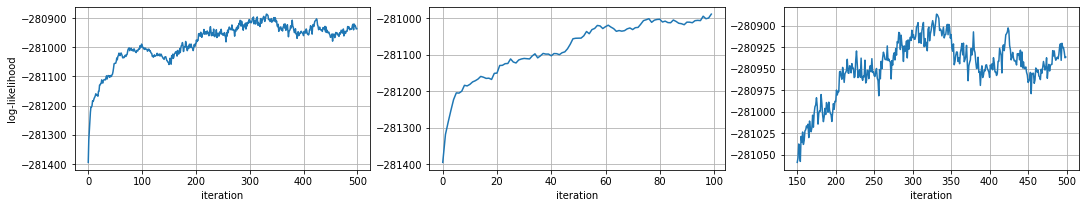

In [25]:
model.samples.plot_log_likelihood()


f_samples.shape: (80, 1, 3, 3, 250)
accept ratio: 0.15309672929714682 220 1437


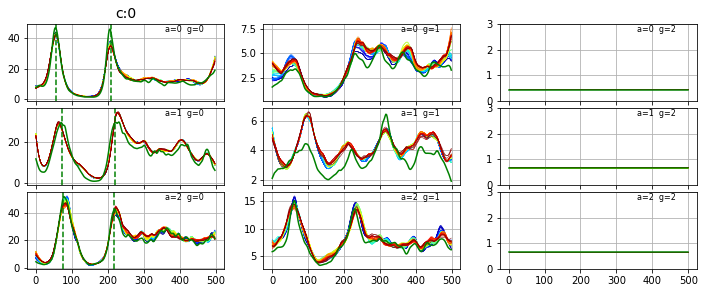

In [26]:
model.samples.plot_f_pop_rainbow([0], spike_train_time_line, burn_in=100, end=None, step=5,
                                 f_pop_cag_ref=generator_model.f_pop_cag,
                                 f_peak1_ac_ref=model.f_peak1_ac, f_peak2_ac_ref=model.f_peak2_ac)

Estimated corr:0.679  p-value:2.403e-09
Accept ratio: 0.2799666666666667 min: 0.052 max: 0.44
num_qs: 60
q_samples.shape:  (501, 3, 60, 1)


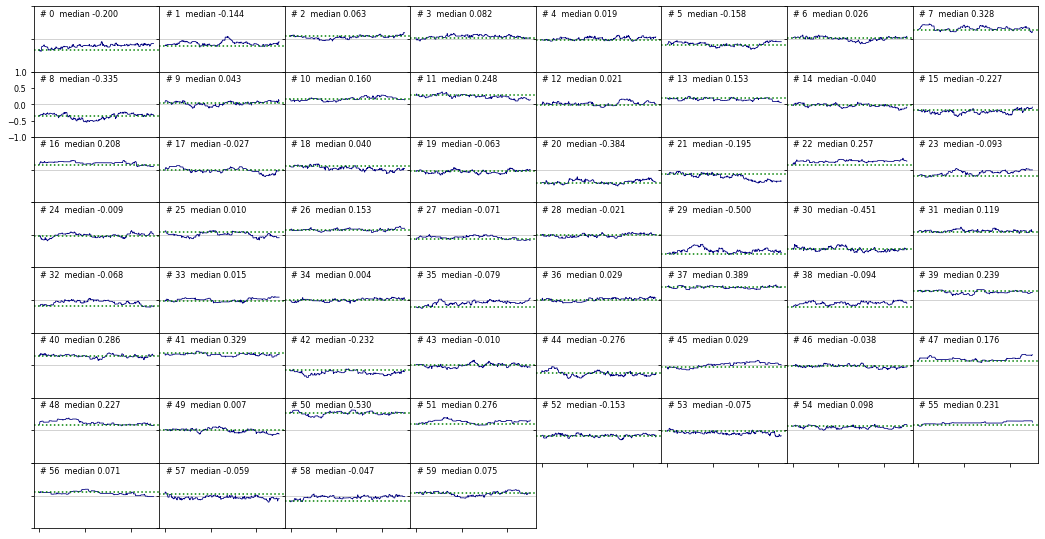

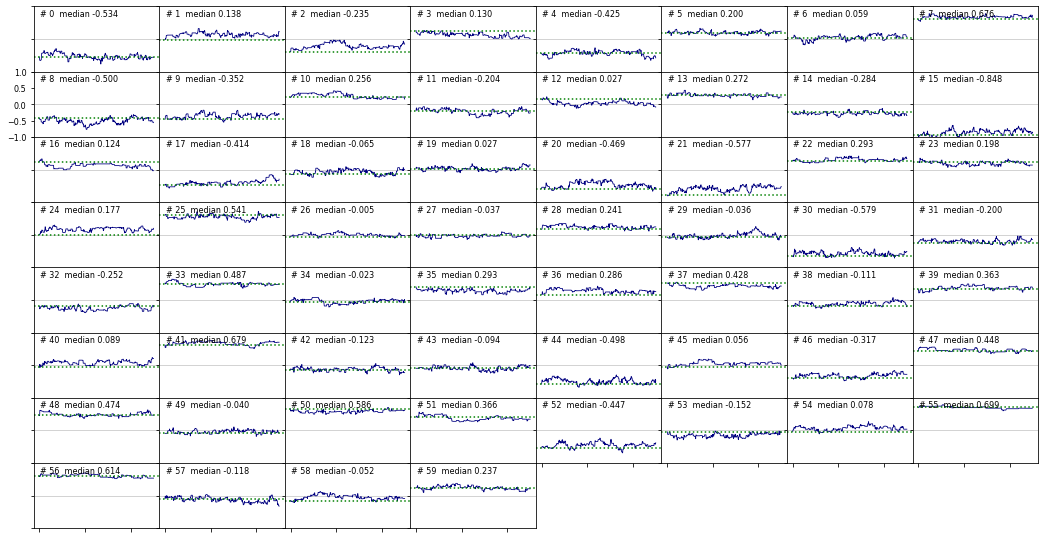

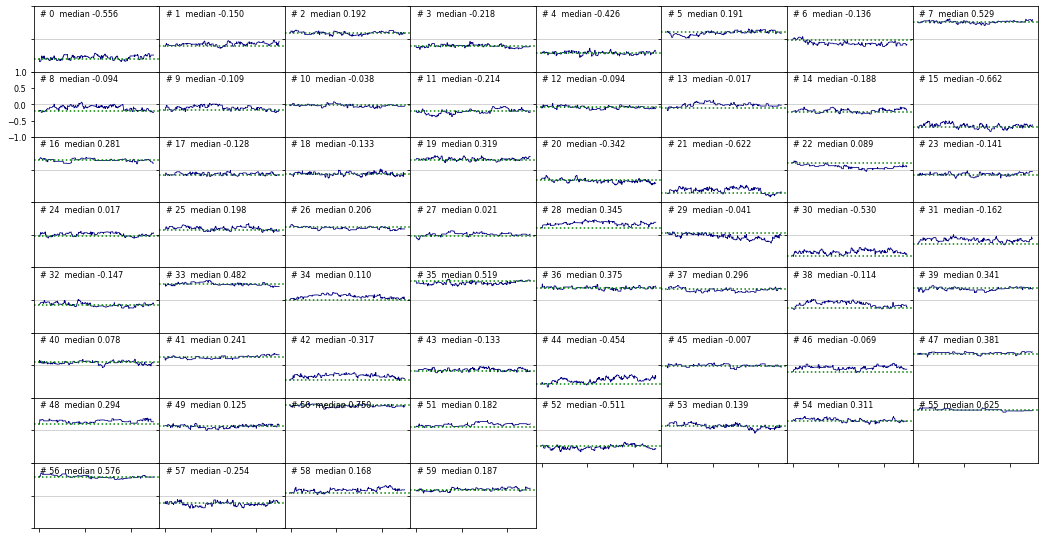

In [27]:
model.samples.plot_q_arc([0], burn_in=0, end=None, option='q', q_arc_ref=generator_model.q_arc)
# model.samples.plot_q_arc([0], burn_in=0, end=None, option='q_shift1', q_shift1_arc_ref=generator_model.q_shift1_arc)
# model.samples.plot_q_arc([0], burn_in=0, option='q_shift2', q_shift2_arc_ref=generator_model.q_shift2_arc)

sigma_samples.shape: (350, 9, 9)


D:/Brain_Network/Code\util.py:585: RuntimeWarning: divide by zero encountered in true_divide
  z = 0.5 * np.log((1 + rho) / (1 - rho))
D:/Brain_Network/Code\util.py:585: RuntimeWarning: divide by zero encountered in true_divide
  z = 0.5 * np.log((1 + rho) / (1 - rho))


CI traps hat total, ratio: 36.0 1.0
CI traps true total, ratio: 36.0 1.0


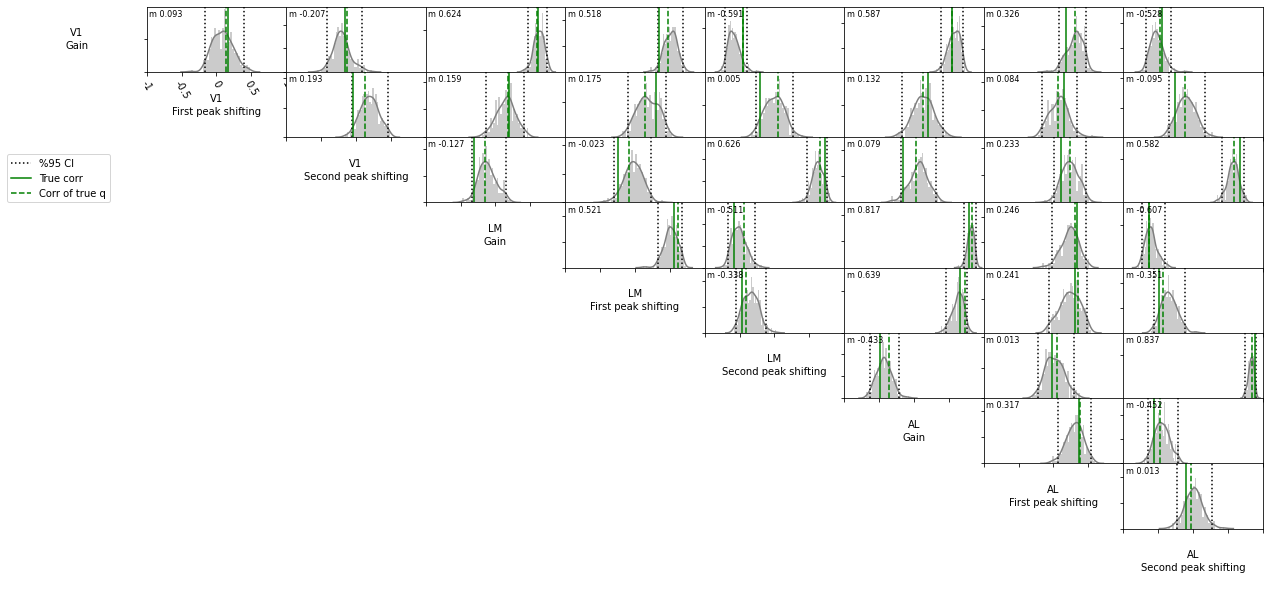

In [29]:
_=model.samples.plot_marginal_correlation(0, 1, burn_in=100, end=None, step=1, plot_type='rho',
        true_model=generator_model, model_feature_type=model.model_feature_type,
        distribution_type='hist')
